# USNCCM15 Short Course
# SC15-005: Machine Learning Data-Driven Discretization Theories, Modeling and Applications

# Hands-on tutorial on Multi-fidelity modeling with Gaussian Processes 
# Instructor: Paris Perdikaris, pgp@seas.upenn.edu
# Code repository: https://github.com/PredictiveIntelligenceLab/USNCCM15-Short-Course-Recent-Advances-in-Physics-Informed-Deep-Learning

# Nonlinear regression with Gaussian Processes

The core of the multi-fidelity framework discussed in this course relies on the formulation of surrogate models  using Gaussian process regression. 
To this end, we employ a Bayesian non-parametric regression framework to model $N$ scattered scalar observations $y$ 
as a realization of a Gaussian process (GP) $f({ x})$, ${ x}\in\mathbb{R}^{d}$. 

## Prior specification
Starting from the single-fidelity case, we can describe this observation model as: 

$$
y = f({ x}) + \epsilon,
$$

where $\epsilon$ represents the noise that may be currupting the observed outputs $y$ and is assumed to be a zero-mean Gaussian random variable, i.e.,
$\epsilon\sim\mathcal{N}(0,\sigma_{n}^{2}I)$, where the variance $\sigma_{n}^{2}$ is a-priori unkown and will be determined by the observed data.
The prior distribution on $f({ x})$ is completely characterized by a mean function 
$\mu({ x})$ (typically assumed to be zero), and covariance kernel function $k({ x}, { x'};\theta)$ function,
where $\theta$ is a vector of hyper-parameters. Typically, the choice of the prior reflects our belief
on the structure, regularity, and other intrinsic properties of the unkown function $f(x)$. For example, the widely used square exponential kernel function with hyper-paramters $(\sigma_f^2, l_1^2,\dots,l_d^2)$

$$
k({ x}, { x'};\theta) = \sigma_f^2 \exp\left(-\frac{1}{2}\sum\limits_{i=1}^{d} \frac{(x_i - x_i')^2}{l_i^2}\right)
$$
is known to model smooth functions with infinitely many continuous derivatives.

## Model training
Our primary goal here is not just drawing function realizations from the Gaussian process prior prior but to incorporate the
knowledge contained in the observations $y$ in order to learn the fucntion $f(x)$.
Model training is performed through minimizing the negative log-marginal likelihood of the Gaussian process model (see \cite{rasmussen2006gaussian}). In our setup, the negative log-marginal likelihood corresponsing to a zero mean GP prior be computed in a closed analytical form
$$
\mathcal{L}(\theta) :=  \frac{1}{2}\log|{K}+\sigma_{n}^{2}{I}| + \frac{1}{2}{y}^{T} ({K}+\sigma_{n}^{2}{I})^{-1}{y} + \frac{N}{2}\log (2\pi)
$$
where ${K}$ is a $N\times N$ covariance matrix constructed by evaluating the kernel function $k(\cdot,\cdot;\theta)$ at the locations of the input training data in the $(n\times d)$ design matric ${X}$. The minimization here is carried out using the quasi-Newton optimizer L-BFGS, and convergence to poor local minima can be mitigated using random restarts (\cite{liu1989limited,rasmussen2006gaussian}).

## Predictive posterior distribution
Finally, once the model has been trained on the available data, we can compute the posterior predictive distribution at a new location ${x}^{\ast}$, namely $p({y}^{\ast}|{x}^{\ast},\mathcal{D})\sim\mathcal{N}(\mu({x}^{\ast}), \Sigma({x}^{\ast}))$, by conditioning on the  observed data as
\begin{align}
\mu({x}^{\ast})  & =  k({x}^{\ast}, {X}) ({K} + \sigma_{n}^{2})^{-1}{y} \label{eq:posterior_mean} \\
\Sigma({x}^{\ast}) & =  k({x}^{\ast}, {x}^{\ast}) - k({x}^{\ast}, {X}) ({K} + \sigma_{n}^{2})^{-1} k({X},{x}^{\ast}) \label{eq:posterior_variance}
\end{align}
Where $\mu$ represents posterior predictive distribution and $\Sigma$ the associated uncertainty.






# Multi-fidelity Gaussian processes

We can extend the single-fidelity $\mathcal{GP}$ regression formulation to handle cases involving data coming from different information sources of variable fidelity (see \cite{kennedy2000predicting,perdikaris2016multifidelity,perdikaris2016model}). 

For simplicity, here we outline the process corresponding to two levels of fidelity, although this can be generalized to arbitrarily many levels. In a two-level multi-fidelity setting we observe data 
$$
\mathcal{D}= [\{({x}_{L_i}, y_{L_i})_{i=1}^{N_{L}}\}, \{({x}_{H_i}, y_{H_i})_{i=1}^{N_{H}}\}] = \{{X},{y}\},
$$
where $({x}_{L}, {y}_{L})$ and $({x}_{H}, {y}_{H})$ are input/output pairs generated by a low- and high-fidelity model, respectively, typically with number of low-fidelity data $N_{L}$ and high-fidelity data $N_H$ such as $N_L>>N_{H}$. Then, our goal is to set up a multi-variate regression framework that can return accurate high-fidelity predictions while being primarily trained on low-fidelity data. To do so, we consider the following multi-output Gaussian process regression model first put forth by \cite{kennedy2000predicting}

\begin{align}
& {y}_{L}  =  f_{L}({x}_{L}) + \epsilon_{L} \\
& {y}_{H}  =  f_{H}({x}_{H}) + \epsilon_{H} \\
& f_{H}({x})  =  \rho f_{L}({x}) + \delta({x}) \\
& f_{L}({x}) \sim \mathcal{GP}(0, k_{L}({x};{x}';\theta_{L}), \qquad \epsilon_{L}\sim\mathcal{N}({0}, \sigma_{n_L}^{2}{I}) \\ & \delta({x}) \sim \mathcal{GP}(0, k_{H}({x};{x}';\theta_{H}),
\qquad \epsilon_{H}\sim\mathcal{N}({0}, \sigma_{n_H}^{2}{I})
\end{align}

where ${x}$ and ${x}'$ represent two input pairs.
Here $f_{L}({x})$ and $\delta({x})$ are considered to be two independent Gaussian processes, $\rho$ is a scaling parameter that is learned during model training along with the variances $\sigma_{n_L}^{2}$ and $\sigma_{n_H}^{2}$ that potentially corrupt the low- and high-fidelity data, respectively. As a consequence of the auto-regressive assumption, the joint distribution of the low- and high-fidelity data inherits the following structure

$$
{y}=\left[ \begin{array}{c} {y}_{L} \\ {y}_{H} \end{array} \right] 
\sim \mathcal{N}\left(\left[\begin{array}{c} {0} \\ {0} \end{array} \right],  
\left[ \begin{array}{c c} {K}_{LL} & {K}_{LH}
 \\  & {K}_{HH}
 \end{array} \right]\right) 
$$

Being 
$$
\begin{split}
&{K}_{LL}=k_{L}({x}_{L},{x}_{L}';\theta_{L}) + \sigma_{\epsilon_{L}}^{2}{I} \\
&{K}_{LH}=\rho k_{L}({x}_{L},{x}_{H};\theta_{L}) \\
&{K}_{HH}=\rho^2 k_{L}({x}_{H},{x}_{H}';\theta_{L}) + k_{H}({x}_{H},{x}_{H}';\theta_{H})  + \sigma_{\epsilon_{H}}^{2}{I}\\
\end{split}
$$

Evidently, the covariance of ${y}$ now has a block structure, where the diagonal blocks model the data in each fidelity level and the off-diagonal blocks model the cross-correlation structure between different levels of fidelity. Model training and posterior predictions can now be performed by using the concatenated low- and high-fidelity data along with this block covariance matrix structure replacing the ${K}$ matrix the operations described in the previous section. In this case, the minimization of the log-marginal likelihood in 
 will return the optimal set of model parameters and hyper-parameters, namely $\Theta=\{\theta_L, \theta_H, \rho, \sigma_{n_L}^{2}, \sigma_{n_H}^{2}\}$, which can be subsequently used to perform posterior predictions by using the posterior predictive distribution presented above, albeit with the correct $K$ matrix corresponding to the multi-fidelity case. 

Note: The main cost associated with the construction of Gaussian process surrogates comes from inverting the dense covariance matrices appearing in the objective function that we optimize during model training. This cost scales cubically with the total number of training points, thus introducing a severe computational bottleneck in cases where a vast number of data exists. This limitation of Gaussian process regression has been effectively mitigated by algorithms presented in a recent body of literature (see \cite{snelson2006sparse,hensman2013gaussian,raissi2017parametric,perdikaris2016multifidelity}). 

## Python/Autograd implementation

Let us know study a basic Python/Autograd implementation for a multi-fidelity Gaussian process regression with two levels of fidelity. To run this code, please make sure that the following dependencies are correctly installed:

Numpy: https://github.com/numpy/numpy

SciPy: https://github.com/scipy/scipy

Autograd: https://github.com/HIPS/autograd

PyDOE: https://github.com/tisimst/pyDOE

Matplotlib: https://github.com/matplotlib/matplotlib

In [35]:
# Import required packages
import autograd.numpy as np
from autograd import value_and_grad
from scipy.optimize import minimize
from pyDOE import lhs
import matplotlib.pyplot as plt

np.random.seed(321)

In [36]:
# A minimal GP multi-fidelity class (two levels of fidelity)
class Multifidelity_GP:
    # Initialize the class
    def __init__(self, X_L, y_L, X_H, y_H):           
        # Number of training data
        self.N_L = y_L.shape[0]
        self.N_H = y_H.shape[0]
        
        # Concatenate data
        X = np.concatenate([X_L, X_H], axis = 0)
        y = np.concatenate([y_L, y_H], axis = 0)
        
        # Normalize data
        self.Xmean, self.Xstd = X.mean(0), X.std(0)
        self.Ymean, self.Ystd = y.mean(0), y.std(0)
        X = (X - self.Xmean) / self.Xstd
        y = (y - self.Ymean) / self.Ystd
        
        # Store data in class
        self.D = X_H.shape[1]
        self.X_L = X[:N_L,:]
        self.y_L = y[:N_L,:]
        self.X_H = X[N_L:,:]
        self.y_H = y[N_L:,:]
        
        # Initialize hyper-parameters
        self.hyp = self.init_params()
        print("Total number of parameters: %d" % (self.hyp.shape[0]))
        
        # Set jitter value to mitigate ill-conditioning
        self.jitter = 1e-8

    # Initialize hyper-parameters        
    def init_params(self):
        hyp = np.log(np.ones(self.D+1))
        self.idx_theta_L = np.arange(hyp.shape[0])
        
        hyp = np.concatenate([hyp, np.log(np.ones(self.D+1))])
        self.idx_theta_H = np.arange(self.idx_theta_L[-1]+1, hyp.shape[0])
        
        rho = np.array([1.0])
        logsigma_n = np.array([-4.0, -4.0])
        hyp = np.concatenate([hyp, rho, logsigma_n])
        return hyp
    
    # A simple vectorized rbf kernel
    def kernel(self,x,xp,hyp):
        output_scale = np.exp(hyp[0])
        lengthscales = np.exp(hyp[1:])
        diffs = np.expand_dims(x /lengthscales, 1) - \
                np.expand_dims(xp/lengthscales, 0)
        return output_scale * np.exp(-0.5 * np.sum(diffs**2, axis=2))
        
    # Computes the negative log-marginal likelihood
    def likelihood(self, hyp):
        X_L = self.X_L
        y_L = self.y_L
        X_H = self.X_H
        y_H = self.y_H

        y = np.vstack((y_L,y_H))
        
        NL = y_L.shape[0]
        NH = y_H.shape[0]
        N = y.shape[0]
        
        # Fetch hyper-parameters
        rho = hyp[-3]
        logsigma_n_L = hyp[-2]
        logsigma_n_H = hyp[-1]        
        sigma_n_L = np.exp(logsigma_n_L)
        sigma_n_H = np.exp(logsigma_n_H)
        
        theta_L = hyp[self.idx_theta_L]
        theta_H = hyp[self.idx_theta_H]
        
        # Construct the kernel blocks
        K_LL = self.kernel(X_L, X_L, theta_L) + np.eye(NL)*sigma_n_L
        K_LH = rho*self.kernel(X_L, X_H, theta_L)
        K_HH = rho**2 * self.kernel(X_H, X_H, theta_L) + \
                        self.kernel(X_H, X_H, theta_H) + np.eye(NH)*sigma_n_H
        # Assemble the covariance matrix
        K = np.vstack((np.hstack((K_LL,K_LH)),
                       np.hstack((K_LH.T,K_HH))))
        # Compute Cholesky factors
        L = np.linalg.cholesky(K + np.eye(N)*self.jitter) 
        self.L = L
        
        # Evaluate the negative log-marginal likelihood
        alpha = np.linalg.solve(np.transpose(L), np.linalg.solve(L,y))    
        NLML = 0.5*np.matmul(np.transpose(y),alpha) + \
               np.sum(np.log(np.diag(L))) + 0.5*np.log(2.*np.pi)*N  
        return NLML[0,0]
    
    # Minimizes the negative log-marginal likelihood using L-BFGS (autodiff gradients via Autograd)
    def train(self):
        result = minimize(value_and_grad(self.likelihood), self.hyp, jac=True, 
                          method='L-BFGS-B', callback=self.callback)
        self.hyp = result.x
        
    # Return the high-fidelity posterior mean and variance at a set of test points
    def predict(self,X_star):
        # Normalize inputs
        X_star = (X_star - self.Xmean) / self.Xstd
        
        X_L = self.X_L
        y_L = self.y_L
        X_H = self.X_H
        y_H = self.y_H
        L = self.L
        
        y = np.vstack((y_L,y_H))
        
        # Fetch hyper-parameters
        rho = self.hyp[-3]
        theta_L = self.hyp[self.idx_theta_L]
        theta_H = self.hyp[self.idx_theta_H]
                   
        # Construct matrices needed for computing the predictive posterior
        psi1 = rho*self.kernel(X_star, X_L, theta_L)
        psi2 = rho**2 * self.kernel(X_star, X_H, theta_L) + \
                        self.kernel(X_star, X_H, theta_H)
        psi = np.hstack((psi1,psi2))

        # Compute the predictive posterior mean
        alpha = np.linalg.solve(np.transpose(L), np.linalg.solve(L,y))
        pred_u_star = np.matmul(psi,alpha)

        # Compute the predictive posterior covariance
        beta = np.linalg.solve(np.transpose(L), np.linalg.solve(L,psi.T))
        var_u_star = rho**2 * self.kernel(X_star, X_star, theta_L) + \
                     self.kernel(X_star, X_star, theta_H) - np.matmul(psi,beta)
        
        # De-normalize outputs
        pred_u_star = pred_u_star*self.Ystd + self.Ymean
        var_u_star = var_u_star*self.Ystd**2
        
        # Fix some auto-grad compatibility issue
        if isinstance(pred_u_star, np.ndarray) == False:
            pred_u_star = pred_u_star._value
        if isinstance(var_u_star, np.ndarray) == False:
            var_u_star = var_u_star._value
            
        return pred_u_star, var_u_star
        
    #  Prints the negative log-marginal likelihood at each training step         
    def callback(self,params):
        print("Log likelihood {}".format(self.likelihood(params)))

# Example simulation

Now we are ready to set up and execute our first multi-fidelity GP simulation. Here we will consider a simple synthetic dataset in one dimension given by the following low- and high-fidelity functions in the domain $x\in[0,1]$:

$$
f_h(x) = (6x-2)^2 \sin(12x-4),
$$
$$
f_l(x) = 0.5f_h(x) + 10(x-0.5) - 5.
$$


In [37]:
# High-fidelity data generator
def f_H(x):
    return (6.0*x-2.0)**2 * np.sin(12.*x-4.0)

# Low-fidelity data generator
def f_L(x):
    return 0.5*f_H(x) + 10.0*(x-0.5) - 5.0

# Number of training data
N_H = 4
N_L = 11

# Dimension of input variables
D = 1

# Bounds of the input domain
lb = 0.0*np.ones(D)
ub = 1.0*np.ones(D)

# Noise corrupting the training data
noise_L = 0.00
noise_H = 0.00

    
# Generate low-fidelity training data    
X_L = lb + (ub-lb)*lhs(D, N_L)
y_L = f_L(X_L)
y_L = y_L + np.std(y_L)*noise_L*np.random.randn(N_L,1)

# Generate high-fidelity training data    
X_H = lb + (ub-lb)*lhs(D, N_H)
y_H = f_H(X_H)
y_H = y_H + np.std(y_H)*noise_H*np.random.randn(N_H,1)

# Test data to validate the model predictions
nn = 200
X_star = np.linspace(lb, ub, nn)
y_star = f_H(X_star)

In [38]:
# Define the multi-fidelity GP model
model = Multifidelity_GP(X_L, y_L, X_H, y_H)

Total number of parameters: 7


In [39]:
# Train the model with L-BFGS
model.train()

Log likelihood 7.790322061804361
Log likelihood 7.537996086327601
Log likelihood 6.620982935910643
Log likelihood 5.549888677133739
Log likelihood 4.223746694374004
Log likelihood 1.6158616795698801
Log likelihood 0.08350691869531168
Log likelihood -1.0982131582695818
Log likelihood -2.9270478554399855
Log likelihood -4.069175362301673
Log likelihood -4.937840971602858
Log likelihood -5.2196214394098615
Log likelihood -5.268521097532156
Log likelihood -5.490614295652504
Log likelihood -5.60059943344511
Log likelihood -5.684485878366152
Log likelihood -5.781093175255597
Log likelihood -5.852538987000292
Log likelihood -5.964300170946194
Log likelihood -6.167502529005988
Log likelihood -6.849560351011155
Log likelihood -6.997625420234639
Log likelihood -7.72170374099789
Log likelihood -8.424294943023563
Log likelihood -8.543215553240417
Log likelihood -8.60580554251752
Log likelihood -8.607707287266775
Log likelihood -8.608386203728143
Log likelihood -8.608747489560079
Log likelihood -8.

In [40]:
# Compute predictions using the trained model
y_pred, y_var = model.predict(X_star)
y_var = np.abs(np.diag(y_var))
error = np.linalg.norm(y_pred-y_star,2)/np.linalg.norm(y_star,2)
print("Relative L2 error u: %e" % (error))

Relative L2 error u: 2.488585e-02


Text(0, 0.5, '$f(x)$')

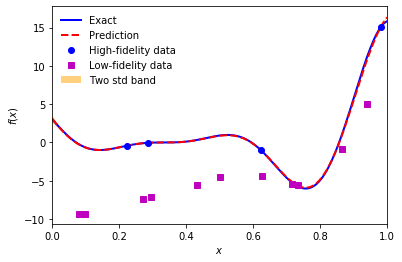

In [41]:
# Plotting

# Plot
plt.figure(1)
plt.plot(X_star, y_star, 'b-', label = "Exact", linewidth=2)
plt.plot(X_star, y_pred, 'r--', label = "Prediction", linewidth=2)
lower = y_pred - 2.0*np.sqrt(y_var[:,None])
upper = y_pred + 2.0*np.sqrt(y_var[:,None])
plt.fill_between(X_star.flatten(), lower.flatten(), upper.flatten(), 
                 facecolor='orange', alpha=0.5, label="Two std band")
plt.plot(X_H,y_H,'bo', label = "High-fidelity data")
plt.plot(X_L,y_L,'ms', label = "Low-fidelity data")
plt.legend(frameon=False,loc='upper left')
ax = plt.gca()
ax.set_xlim([lb[0], ub[0]])
plt.xlabel('$x$')
plt.ylabel('$f(x)$')